In [2]:
#Import libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import statsmodels.api as sm

In [26]:
#load in our dataset
df = pd.read_csv("Resources/mountain_pastured_cows.csv")
display(df.head())

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72


### Data Exploration

In [4]:
#check dtypes
df.dtypes

newid               int64
lact_num            int64
calv_date          object
alp_date           object
avg_milk          float64
avg_thi3          float64
avg_csi3          float64
avg_thi30         float64
avg_csi30         float64
avg_precspring    float64
dtype: object

In [5]:
#check for nulls, negligible amount, should be clear to dropna
print(df.isna().sum()/len(df))
print(df.shape)

newid             0.00000
lact_num          0.00000
calv_date         0.00000
alp_date          0.00000
avg_milk          0.00000
avg_thi3          0.00205
avg_csi3          0.00205
avg_thi30         0.00205
avg_csi30         0.00205
avg_precspring    0.00000
dtype: float64
(20000, 10)


In [6]:
df = df.dropna()
print(df.shape)

(19959, 10)


In [7]:
df["avg_milk"].describe()

count    19959.000000
mean        15.921083
std          4.078102
min          3.500000
25%         13.070000
50%         15.600000
75%         18.500000
max         40.370000
Name: avg_milk, dtype: float64

### Feature Engineering

In [8]:
# Example: converting 'calv_date' and 'alp_date' columns to datetime
df['calv_date'] = pd.to_datetime(df['calv_date'])
df['alp_date'] = pd.to_datetime(df['alp_date'])

display(df.head())
print(df.dtypes)


,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72


newid                      int64
lact_num                   int64
calv_date         datetime64[ns]
alp_date          datetime64[ns]
avg_milk                 float64
avg_thi3                 float64
avg_csi3                 float64
avg_thi30                float64
avg_csi30                float64
avg_precspring           float64
dtype: object


In [9]:
# Calculate the difference
df['date_diff'] = (df['alp_date'] - df['calv_date']).dt.days

df.head()

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring,date_diff
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61,106
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40,218
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08,281
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96,254
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72,262


In [10]:
#Replace datetime columns with numerical

# df['calv_year'] = df['calv_date'].dt.year | causes multicollinearity issues
df['calv_month'] = df['calv_date'].dt.month
df['calv_day_of_month'] = df['calv_date'].dt.day

# df['alp_year'] = df['alp_date'].dt.year | causes multicollinearity issues
df['alp_month'] = df['alp_date'].dt.month
df['alp_day_of_month'] = df['alp_date'].dt.day

df.head()

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring,date_diff,calv_month,calv_day_of_month,alp_month,alp_day_of_month
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61,106,2,19,6,5
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40,218,11,9,6,15
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08,281,9,16,6,24
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96,254,10,18,6,29
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72,262,9,14,6,2


In [11]:
df.dtypes

newid                         int64
lact_num                      int64
calv_date            datetime64[ns]
alp_date             datetime64[ns]
avg_milk                    float64
avg_thi3                    float64
avg_csi3                    float64
avg_thi30                   float64
avg_csi30                   float64
avg_precspring              float64
date_diff                     int64
calv_month                    int32
calv_day_of_month             int32
alp_month                     int32
alp_day_of_month              int32
dtype: object

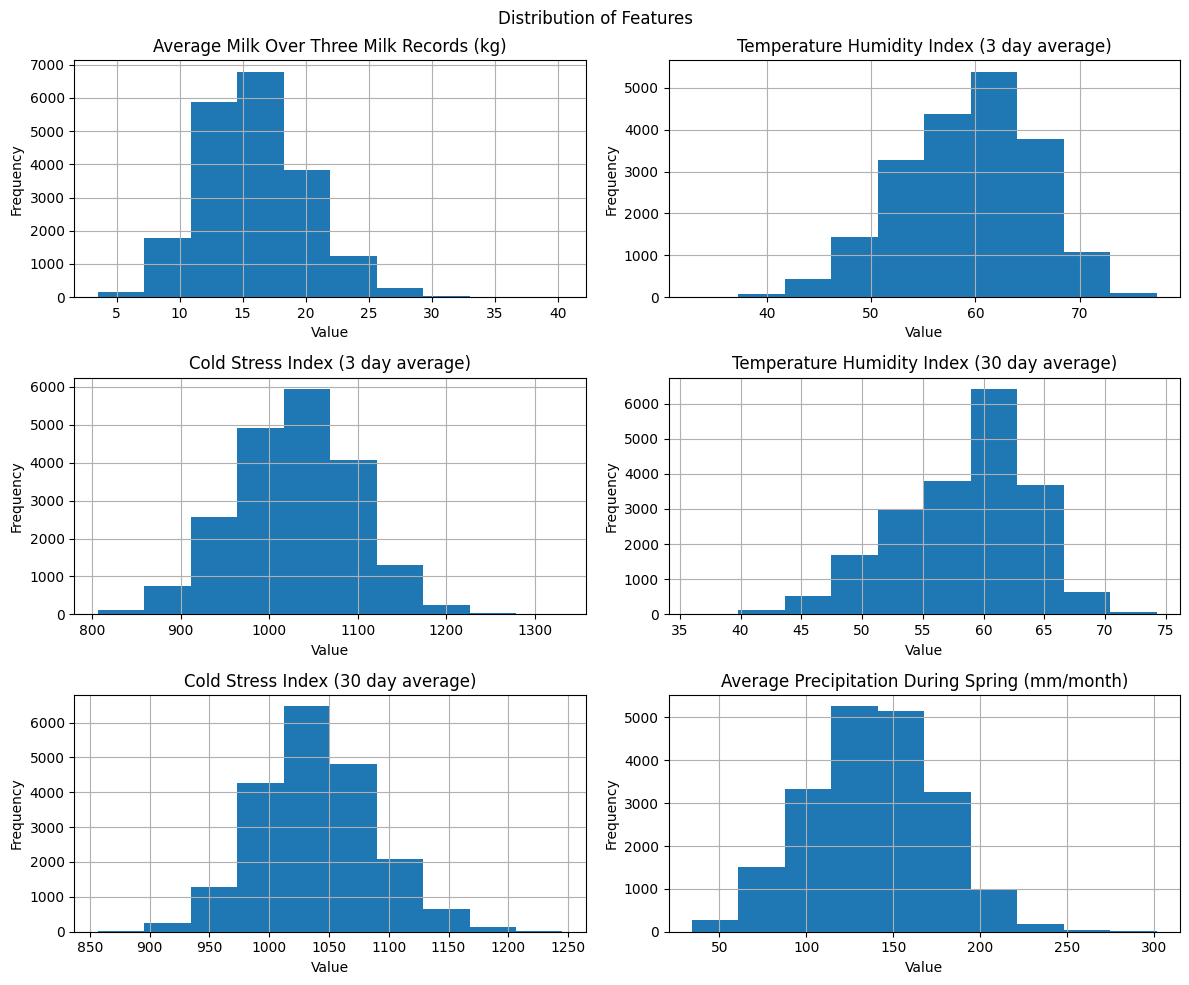

TypeError: Figure.savefig() missing 1 required positional argument: 'fname'

<Figure size 640x480 with 0 Axes>

In [27]:
# Visualize distributions of numeric columns
numeric_columns = ['avg_milk', 'avg_thi3', 'avg_csi3', 'avg_thi30', 'avg_csi30', 'avg_precspring']
axes = df[numeric_columns].hist(figsize=(12, 10))
plt.suptitle("Distribution of Features")
# Add Labels for each fig
titles = ['Average Milk Over Three Milk Records (kg)', 'Temperature Humidity Index (3 day average)', 'Cold Stress Index (3 day average)',
          'Temperature Humidity Index (30 day average)','Cold Stress Index (30 day average)', 'Average Precipitation During Spring (mm/month)']
xlabel = "Value"
ylabel = "Frequency"
for fig, title in zip(axes.flatten(), titles):
    fig.set_title(title)
    fig.set_xlabel(xlabel)
    fig.set_ylabel(ylabel)
# show charts
plt.tight_layout()
plt.show()
plt.savefig('Resources/Average Milk Over Three Milk Records (kg).png')

## Preporccessing Data

### Data Leakage 

In [13]:
df.columns

Index(['newid', 'lact_num', 'calv_date', 'alp_date', 'avg_milk', 'avg_thi3',
       'avg_csi3', 'avg_thi30', 'avg_csi30', 'avg_precspring', 'date_diff',
       'calv_month', 'calv_day_of_month', 'alp_month', 'alp_day_of_month'],
      dtype='object')

In [14]:
features = ['lact_num', 'avg_milk', 'avg_thi3', 'avg_csi3', 'avg_csi30',
       'avg_precspring', 'date_diff', 'calv_month',
       'calv_day_of_month', 'alp_month', 'alp_day_of_month']

# Calculate VIF
X = df[features]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]

print(vif_data)

              Feature          VIF
0               const  4350.541432
1            lact_num     1.093165
2            avg_milk     1.583383
3            avg_thi3     6.963646
4            avg_csi3     3.926807
5           avg_csi30     2.587901
6      avg_precspring     1.268668
7           date_diff     2.117705
8          calv_month     2.834302
9   calv_day_of_month     1.015470
10          alp_month     1.502374
11   alp_day_of_month     1.388929


In [15]:
# remove problematic or no longer needed columns
df = df.drop(["newid",'avg_thi30', 'calv_date', 'alp_date'], axis = 1)
df.head()

,lact_num,avg_milk,avg_thi3,avg_csi3,avg_csi30,avg_precspring,date_diff,calv_month,calv_day_of_month,alp_month,alp_day_of_month
0,5,26.20,60.17,966.13,1038.28,134.61,106,2,19,6,5
1,5,12.20,66.08,917.76,1111.54,184.40,218,11,9,6,15
2,3,14.60,66.78,899.06,1000.32,184.08,281,9,16,6,24
3,5,15.17,63.49,1053.80,1037.26,116.96,254,10,18,6,29
4,1,12.03,65.96,969.90,998.60,154.72,262,9,14,6,2


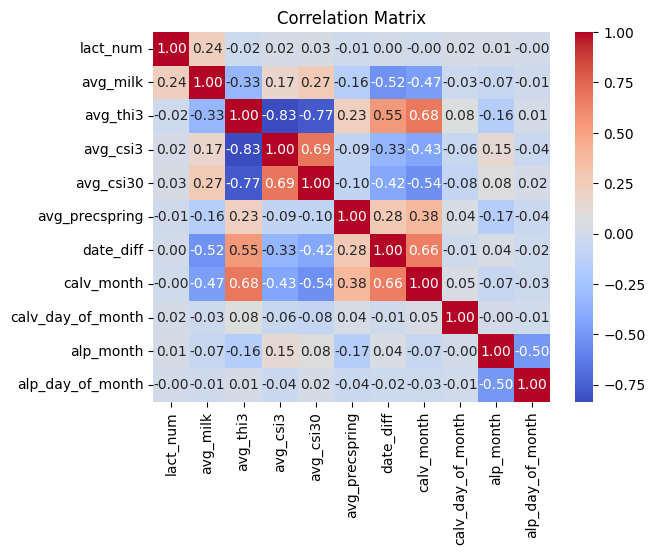

In [16]:
corr_matrix = df[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Model Training 

In [17]:
# Split the features and target data
y = df['avg_milk']
X = df.drop('avg_milk', axis = 1)


In [18]:
# Review the features Dataframe 
display(X.head())
display(y)

,lact_num,avg_thi3,avg_csi3,avg_csi30,avg_precspring,date_diff,calv_month,calv_day_of_month,alp_month,alp_day_of_month
0,5,60.17,966.13,1038.28,134.61,106,2,19,6,5
1,5,66.08,917.76,1111.54,184.40,218,11,9,6,15
2,3,66.78,899.06,1000.32,184.08,281,9,16,6,24
3,5,63.49,1053.80,1037.26,116.96,254,10,18,6,29
4,1,65.96,969.90,998.60,154.72,262,9,14,6,2


0        26.20
1        12.20
2        14.60
3        15.17
4        12.03
         ...  
19995    19.38
19996    23.57
19997    21.23
19998    11.63
19999    10.47
Name: avg_milk, Length: 19959, dtype: float64

In [19]:
# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [20]:
# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

display(X_train_scaled)
display(X_test_scaled)

array([[-0.30741166, -0.21155819,  0.13192995, ...,  0.72095697,
        -1.96420227,  1.46995656],
       [ 0.77316723, -0.92933445,  1.23760228, ...,  1.29769942,
        -0.0429958 , -0.49693931],
       [ 0.77316723,  0.20266511, -0.55633228, ...,  1.5283964 ,
        -0.0429958 ,  1.00715753],
       ...,
       [-0.84770111, -2.32219983,  1.51317257, ..., -0.54787644,
        -0.0429958 ,  0.66005826],
       [-0.30741166, -1.31193765,  1.0039057 , ...,  0.72095697,
        -0.0429958 ,  0.19725924],
       [-0.84770111,  0.52835213, -0.04441145, ...,  0.60560848,
        -0.0429958 , -1.65393688]])

array([[-0.30741166,  0.43665384, -0.35566286, ..., -0.31717945,
        -0.0429958 ,  1.46995656],
       [ 0.77316723, -1.02419475,  0.92340202, ...,  1.75909339,
        -0.0429958 , -0.95973833],
       [-0.84770111, -0.20365317, -0.2365292 , ..., -0.54787644,
        -1.96420227,  0.77575802],
       ...,
       [ 0.77316723,  1.69197179, -1.64165754, ...,  0.259563  ,
        -1.96420227,  1.3542568 ],
       [ 0.23287778, -1.17280921,  0.7967488 , ..., -1.47066437,
        -0.0429958 , -0.95973833],
       [-0.84770111,  1.08960889, -1.31315534, ...,  0.02886602,
        -0.0429958 , -0.38123955]])

## Define the ANN Model

### Create and fit feedforward ANN Model 

In [21]:
# Define the ANN Model
model = Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    layers.Dense(32, activation='relu'),  # Hidden layer 1
    layers.Dense(32, activation='relu'),  # Hidden layer 2
    layers.Dense(1)  # Output layer
])

In [22]:
# Compile the ANN ›model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [23]:
# Fit the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, validation_split=0.2)

Epoch 1/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 459us/step - loss: 77.4260 - mae: 6.6441 - val_loss: 12.2252 - val_mae: 2.7510
Epoch 2/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 11.8772 - mae: 2.6917 - val_loss: 10.8463 - val_mae: 2.5911
Epoch 3/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 10.2214 - mae: 2.4898 - val_loss: 10.0722 - val_mae: 2.4762
Epoch 4/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 10.2126 - mae: 2.4773 - val_loss: 10.0310 - val_mae: 2.4695
Epoch 5/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 10.0541 - mae: 2.4640 - val_loss: 9.9600 - val_mae: 2.4462
Epoch 6/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 9.6290 - mae: 2.4045 - val_loss: 9.6744 - val_mae: 2.4088
Epoch 7/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 9.7463 - mae: 2.4271 - val_loss: 9.6322 - val_mae: 2.4131
Epoch 8/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 9.5990 - mae: 2.4205 - val_loss: 9.6364 - val_mae: 2.4105
Epoch 9

In [24]:
# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f'Mean Absolute Error: {mae}')

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 9.3386 - mae: 2.3893
Mean Absolute Error: 2.434966564178467


In [25]:
# Calculate MAE ********  (For readressing  / review)
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
# Calculate the mean of actual values
mean_actual = np.mean(y_test)
# Calculate the percentage MAE
percentage_mae = (mae / mean_actual) * 100
print(f"Percentage MAE: {percentage_mae:.2f}%")

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
Percentage MAE: 15.22%


MAPE indicates that the model's predictions deviate from the true values by an average of 5.56%